In [1]:
from pathlib import Path

import librosa
import numpy
import pysptk
import pyworld

from become_yukarin.config import create_from_json as create_config
from become_yukarin.data_struct import Wave
from become_yukarin.dataset.dataset import *

from IPython.display import Audio
import matplotlib.pyplot as plt
%matplotlib inline

/Users/kazuyuki_hiroshiba/.pyenv/versions/miniconda3-latest/envs/become-yukarin/lib/python3.6/site-packages/chainer/_environment_check.py:38: UserWarning: Accelerate has been detected as a NumPy backend library.
vecLib, which is a part of Accelerate, is known not to work correctly with Chainer.
We recommend using other BLAS libraries such as OpenBLAS.
For details of the issue, please see
https://docs.chainer.org/en/stable/tips.html#mnist-example-does-not-converge-in-cpu-mode-on-mac-os-x.

Also note that Chainer does not officially support Mac OS X.
Please use it at your own risk.

  ''')  # NOQA


In [2]:
paths = [
    Path('~/dataset/hiho-pause-atr503-subset').expanduser() / 'hiho-pause-atr-A01.wav',
    Path('~/dataset/yukari-pause-atr503-subset').expanduser() / 'yukari-pause-atr-A01.wav',
]

wave_file_load = WaveFileLoadProcess(
    sample_rate=24000,
    top_db=None,
    pad_second=0.01,
)
acoustic_feature = AcousticFeatureProcess(
    frame_period=5,
    order=25,
    alpha=pysptk.util.mcepalpha(wave_file_load._sample_rate),
)

In [3]:
w = wave_file_load(paths[0], test=True)
Audio(data=w.wave, rate=w.sampling_rate)

In [4]:
f = acoustic_feature(w, test=True)

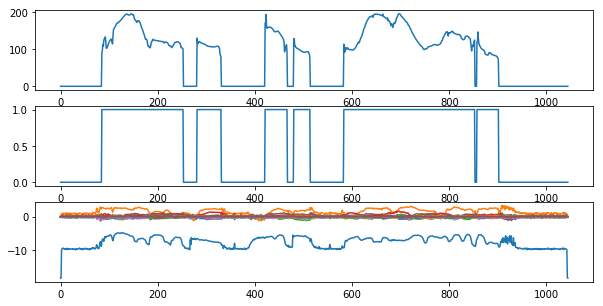

In [5]:
plt.figure(figsize=(10, 5))

plt.subplot(3, 1, 1)
plt.plot(f.f0)

plt.subplot(3, 1, 2)
plt.plot(f.f0!=0)

plt.subplot(3, 1, 3)
_ = plt.plot(f.mfcc)

In [6]:
fftlen = pyworld.get_cheaptrick_fft_size(wave_file_load._sample_rate)

spectrogram = pysptk.mc2sp(
    f.mfcc,
    alpha=acoustic_feature._alpha,
    fftlen=fftlen,
)

f = AcousticFeature(
    f0=f.f0,
    spectrogram=spectrogram,
    aperiodicity=f.aperiodicity,
    mfcc=f.mfcc,
    voiced=f.voiced,
).astype(numpy.float64)

out = pyworld.synthesize(
    f0=f.f0.ravel(),
    spectrogram=f.spectrogram,
    aperiodicity=f.aperiodicity,
    fs=wave_file_load._sample_rate,
    frame_period=acoustic_feature._frame_period,
)

Audio(data=out, rate=wave_file_load._sample_rate)